In [48]:
%%capture
!pip install optuna

# <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


In [49]:
# Импорт необходимых библиотек
import numpy as np           # Для работы с массивами
import pandas as pd          # Для работы с DataFrame
import seaborn as sns        # Библиотека для визуализации статистических данных
import matplotlib.pyplot as plt   # Для построения графиков
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from optuna.logging import set_verbosity, WARNING

# Настройка окружения
%matplotlib inline
sns.set_theme('notebook')      # Установить тему для Seaborn
sns.set_palette('BrBG')        # Установить палитру цветов
random_state = 45              # Фиксированное значение для воспроизводимости результатов

# Подавление всех предупреждений
warnings.filterwarnings('ignore')

# Оставлять только предупреждения и ошибки от Optuna
set_verbosity(WARNING)

# Подгружаем данные для проекта

In [50]:
# %%capture
# !wget https://lms-cdn.skillfactory.ru/assets/courseware/v1/71b705fb3dda956399b2209697366543/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_unconv.zip
# !unzip _unconv.zip

In [51]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


# Знакомство с данными

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [53]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


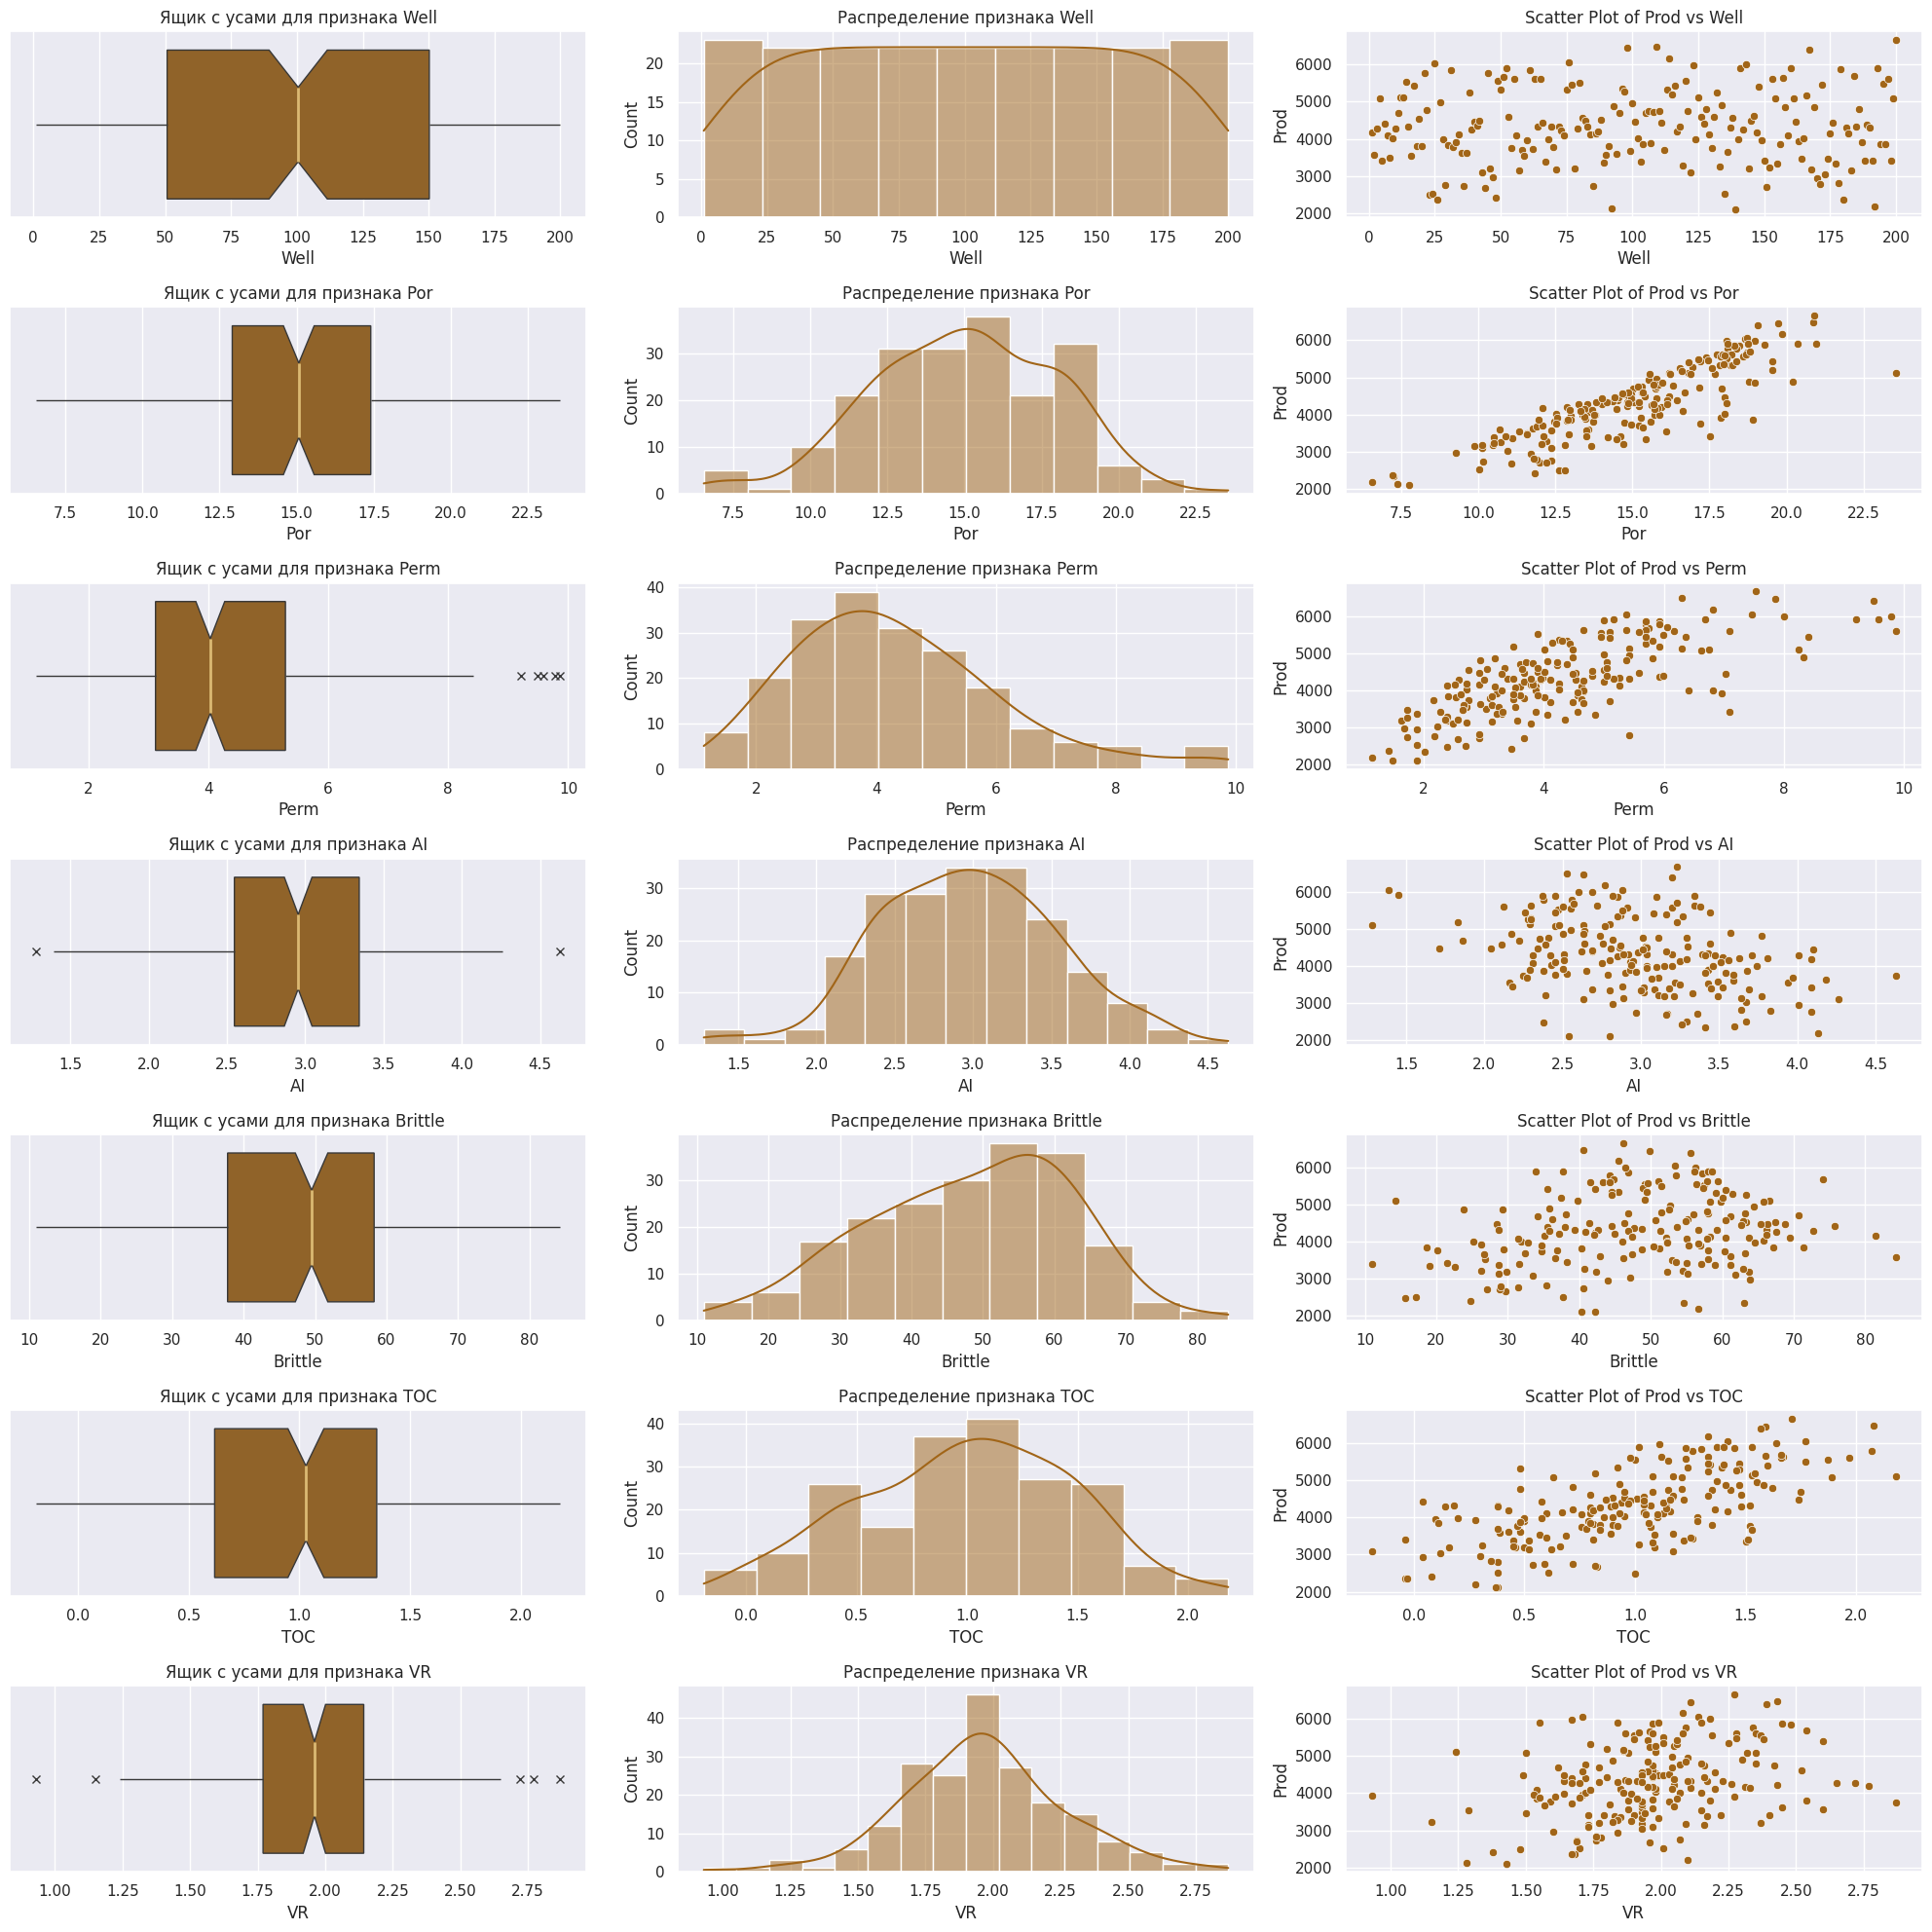

In [54]:
fig, axes = plt.subplots(len(data.columns[:-1]), 3, figsize=(20, 20))

# Цикл для обработки каждого признака (всех столбцов кроме целевого)
for index, col in enumerate(data.columns[:-1]):

    # Создание ящика с усами (boxplot) для текущего признака
    sns.boxplot(
        data=data,
        x=col,
        notch=True,
        showcaps=False,
        flierprops={"marker": "x"},
        medianprops={"color": "C7", "linewidth": 2},
        ax=axes[index][0]
    )
    axes[index][0].set_title(f'Ящик с усами для признака {col}')

    # Создание гистограммы с плотностью вероятности (KDE) для текущего признака
    sns.histplot(
        data=data,
        x=col,
        kde=True,
        ax=axes[index][1]
    )
    axes[index][1].set_title(f'Распределение признака {col}')

    # Создание scatter plot (диаграммы рассеяния) для 'Prod' по каждому признаку
    sns.scatterplot(data=data, x=col, y='Prod', ax=axes[index][2])
    axes[index][2].set_title('Scatter Plot of Prod vs ' + col)
    axes[index][2].set_xlabel(col)
    axes[index][2].set_ylabel('Prod')

# Оптимизация компоновки подграфиков
plt.tight_layout()
plt.show()



>




> ➊ В данных отстутвуют пропуски и дубликаты.
Все признаки в данных - числовые.
>
> ➋ Признак 'Well(Идентификатор скважины)' не несет полезной информации и дублирует просто номера строк в данных (отличие лишь в том, что скажины нумеруются с 1, а строки с 0).
>
> ➌ Имеются признаки с небольшим количеством выбросов:
* Проницаемость скважины (Perm)
* Акустический импеданс (AI)
* Коэффициент отражения витринита (VR)
>
> ➍ В целом, практически все признаки имеют нормальное распределение или близкое к нормальному распределению.
>
> ➎ Исходя из графиков можно судить о линейной зависимости между целевой переменной Prod(добыча газа в стуки) и признаками(Por, Perm, Toc). Чем больше значение признака Por/Perm/Toc, тем выше значение целевой переменной.

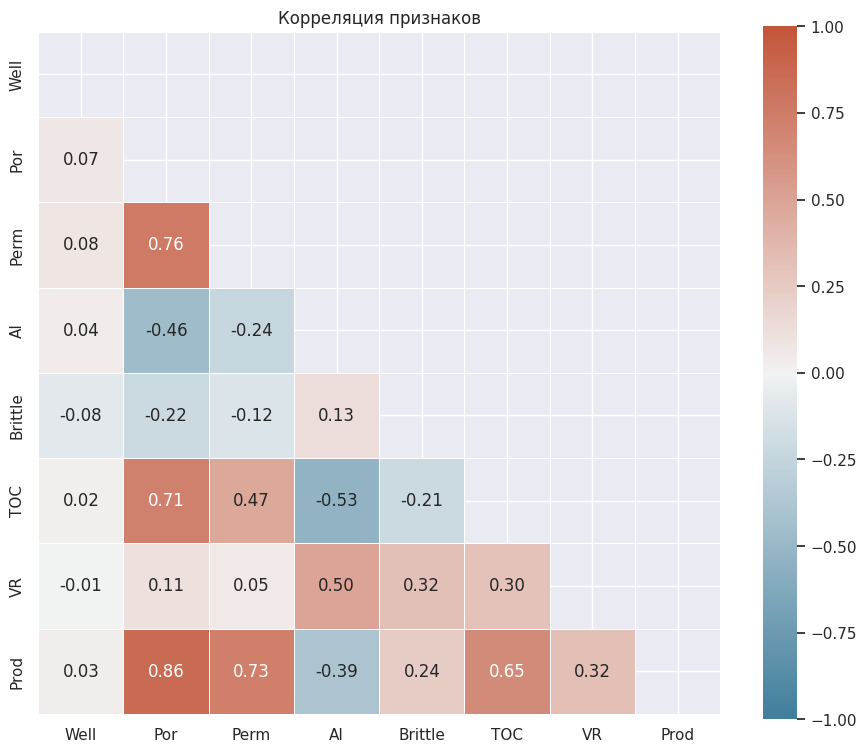

In [55]:
# Посчитаем вручную матрицу корреляций (но можно использовать и data.corr())
data_cent = data - data.mean(axis=0)
data_st = data_cent/np.linalg.norm(data_cent, axis=0)
data_corr = data_st.T @ data_st

mask = np.triu(np.ones_like(data.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Генерирация кастомной палитры
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    data_corr,
    mask=mask,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    )
plt.title('Корреляция признаков');

In [56]:
print(f'Ранг расширенной матрицы равен: {np.linalg.matrix_rank(data_corr)}')
print(f'Ранг матрицы без целевой переменной равен: {np.linalg.matrix_rank(data_corr[:-1])}')
print(f'Определитель матрицы равен: {np.linalg.det(data_corr).round(4)}')


Ранг расширенной матрицы равен: 8
Ранг матрицы без целевой переменной равен: 7
Определитель матрицы равен: 0.0007


>**Использование классической линейной регрессии по методу наименьших квадратов (OLS) может быть проблематичным по следующим причинам:**
>
> * Ранг матрицы признаков меньше ранга расширенной матрицы, что указывает на наличие случая переопределенности. Это означает, что некоторые признаки в матрице являются линейно зависимыми и не вносят дополнительной информации в модель.
Модель не может однозначно оценить все коэффициенты регрессии, так как один или несколько признаков можно выразить через другие. В результате будет сложно интерпретировать значения коэффициентов, и они могут иметь большие стандартные ошибки, что снижает доверие к выводам.
>
> * Кроме того матрица имеет плохую обусловленность, так как определитель её близок к нулю. Это может привести к нестабильности в расчетах, особенно при проведении обратных операций, таких как нахождение коэффициентов регрессии. В результате, малые изменения в данных могут вызывать значительные колебания в оценках модели, что усложняет интерпретацию полученных результатов.

**Корреляция**
Среди признаков имеется свзязь между проницаемостью и пористостью скважины, а также между пористостью и органическим углеродом. Значения корреляции находятся в пределах 0.7-0.8.

С целевой переменной самая сильная связь у признака пористости. Средняя связь с признаком уровня углерода и слабая связь с признаками акустический импеданс и уровень хрупкости скважины.


## Построим модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК.

In [57]:
X = data.drop('Prod', axis=1)
y = data['Prod']

X = np.column_stack((np.ones(200), X))

# вычислим OLS-оценку для коэффициентов
w = np.linalg.inv(X.T@X)@X.T@y


coefficients = pd.DataFrame({'Признаки': ['Свободный член'] + list(data.columns[:-1]), 'Коэффициенты': w.round()})
coefficients

,Признаки,Коэффициенты
0,Свободный член,-1232.0
1,Well,0.0
2,Por,230.0
3,Perm,116.0
4,AI,-365.0
5,Brittle,25.0
6,TOC,-78.0
7,VR,785.0


> **1. Неинформативные признаки**
>
> Признак Well демонстрирует коэффициент, равный 0. Это свидетельствует о том, что данный признак не оказывает влияния на целевую переменную (в данном случае "Prod") и является неинформативным признаком.
>
> **2. Интерпретация коэффициентов**
Рассмотрим интерпретацию нескольких коэффициентов ("Por", "Perm" и "AI"):
>
> * Por (коэффициент 230.0): Этот коэффициент указывает на то, что при увеличении значения признака "Por" на 1 единицу, целевая переменная ("Prod") в среднем увеличится на 230 единиц.
> * Perm (коэффициент 116.0): Увеличение значения признака "Perm" на 1 единицу. Это означает, что более высокие значения "Perm"(проницаемости скважины) способствует более высоким уровням добычи газа в сутки.
> * AI (коэффициент -365): Уменьшение значения признака "AI" на 1 единицу приводит к уменьшению целевой переменной на 365 единиц. Этот коэффициент демонстрирует отрицательное влияние на целевую переменную.
>
>**Выводы**
* Наличие неинформативного признака "Well" подразумевает необходимость его исключения из модели для повышения её точности и уменьшения риска переобучения.
* Признаки "Por", "Perm" и "VR" имеют положительное влияние на целевую переменную "Prod".
* Необходимо проверить статистическую значимость всех коэффициентов, чтобы подтвердить выводы о влиянии признаков на целевую переменную.

## **Построим прогноз выработки газа для скважины со следующими параметрами:**

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```
Известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день.

### Предсказание

In [58]:
new=np.array([[1,106.0, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42]])
print('prediction:', (new@w))

prediction: [4723.06405371]


In [59]:
# Фактическое значение для новой скважины
actual_value = 4748.315024  # миллионов кубических футов в день

# Рассчитываем абсолютную ошибку
absolute_error = abs(actual_value - new@w)

print(f'Прогнозируемое значение: {new@w}')
print(f'Абсолютная ошибка: {absolute_error}')

Прогнозируемое значение: [4723.06405371]
Абсолютная ошибка: [25.25097029]


In [60]:
# Рассчитываем абсолютную ошибку
absolute_error = abs(y - X@w)

df_prediction = pd.DataFrame({
    'Прогнозируемое значение': X@w,
    'Фактическое значение': y,
    'Абсолютная ошибка': absolute_error
})

df_prediction.head(3)

,Прогнозируемое значение,Фактическое значение,Абсолютная ошибка
0,4622.704951,4165.196191,457.508760
1,3412.285098,3561.146205,148.861107
2,4717.273422,4284.348574,432.924848


In [61]:
# Рассчитываем MAE
mae = np.mean(absolute_error)

# Рассчитываем MSE
mse = np.mean(absolute_error ** 2)

print(f'Средняя абсолютная ошибка (MAE): {mae}')
print(f'Средняя квадратичная ошибка (RMSE): {np.sqrt(mse)}')

Средняя абсолютная ошибка (MAE): 153.62297086555168
Средняя квадратичная ошибка (RMSE): 198.28020612321944


> Значения метрик
>
> **Средняя абсолютная ошибка (MAE):**
>
>MAE составляет ~153.6 единиц (в данном случае миллионы кубических футов в день)
Это означает, что в среднем прогнозируемые значения выработки газа отличаются от фактических значений на примерно 153.6 миллиона кубических футов в день.
Поскольку MAE измеряет среднюю величину ошибок, небольшие значения MAE указывают на высокую точность модели.
>
>**Средняя квадратичная ошибка (MSE):**
>
>MSE составляет 39315.04 (в единицах, возведенных в квадрат).
Это значение соответствует средней ошибке модели, но с учетом квадрата разницы между реальными и предсказанными значениями. Из-за возведения в квадрат большие ошибки имеют более значительное влияние на результат.
>
>С помощью MSE будем сравнивать модели: модель с меньшим значением MSE более предпочтительна, так как она показывает меньшие значения ошибки.
>
>MSE значительно больше, чем MAE, это указывает на наличие крупных ошибок в прогнозах.

### Посмотрим на коэффициенты и сравним их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые нашли ранее.

In [62]:
data_corr = data_corr["Prod"].reset_index().rename(columns={'Prod': 'Корреляция'})
merged_data = coefficients[1:].merge(data_corr, left_on='Признаки', right_on='index', how='left').drop('index', axis=1)
merged_data

,Признаки,Коэффициенты,Корреляция
0,Well,0.0,0.026817
1,Por,230.0,0.861910
2,Perm,116.0,0.727426
3,AI,-365.0,-0.390835
4,Brittle,25.0,0.237155
5,TOC,-78.0,0.654445
6,VR,785.0,0.323182


> **Исходя из приведенного анализа, есть одно противоречие:**
>
> Признак TOC: Коэффициент линейной регрессии отрицательный (-78.0), в то время как коэффициент корреляции положительный (0.654445).

>**Причины**
>* Коэффициент при TOC может быть отрицательным из-за влияния других факторов, которые более сильно влияют на целевую переменную.
* Не линейная зависимость: Даже если коэффициент корреляции показывает положительную зависимость, это не всегда предполагает линейную зависимость.
* Если некоторые признаки коррелируют друг с другом, это может влиять на коэффициенты модели.

## Очистим данные от признаков с сильной корреляцией и неинформативных.

In [63]:
X = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
columns_ = X.columns
y = data['Prod']

X = np.column_stack((np.ones(200), X))

# вычислим OLS-оценку для коэффициентов
w = np.linalg.inv(X.T@X)@X.T@y


coefficients = pd.DataFrame({'Признаки': ['Свободный член'] + list(columns_), 'Коэффициенты': w.round()})
coefficients

,Признаки,Коэффициенты
0,Свободный член,-1835.0
1,Por,293.0
2,AI,-200.0
3,Brittle,28.0
4,VR,517.0


Делаем предсказание для новой скважины

In [64]:
new=np.array([[1, 15.32, 3.29, 55.99, 2.42]])

# Фактическое значение для новой скважины
actual_value = 4748.315024  # миллионов кубических футов в день

# Рассчитываем абсолютную ошибку
absolute_error = abs(actual_value - new@w)

print(f'Прогнозируемое значение: {new@w}')
print(f'Абсолютная ошибка: {absolute_error}')

Прогнозируемое значение: [4795.50030618]
Абсолютная ошибка: [47.18528218]


Делаем предсказание дя всего набора данных

In [65]:
# Рассчитываем абсолютную ошибку
absolute_error = abs(y - X@w)

df_prediction = pd.DataFrame({
    'Прогнозируемое значение': X@w,
    'Фактическое значение': y,
    'Абсолютная ошибка': absolute_error
})

display(df_prediction.head(3))

# Рассчитываем RMSE
rmse = np.sqrt(np.mean(absolute_error ** 2))

# Рассчитываем MAPE
mape = np.mean(np.abs((absolute_error / y) * 100))

print(f'Корень среднеквадратичной ошибки (RMSE): {round(rmse, 4)}')
print(f'Средняя абсолютная процентная ошибка (MAPE): {round(mape, 4)}%')

,Прогнозируемое значение,Фактическое значение,Абсолютная ошибка
0,4589.521072,4165.196191,424.324881
1,3397.143992,3561.146205,164.002213
2,4890.396657,4284.348574,606.048083


Корень среднеквадратичной ошибки (RMSE): 231.6481
Средняя абсолютная процентная ошибка (MAPE): 4.0441%


**Изменение коэффициентов**

Por:
Повышение коэффициента с 230.0 до 290.0 указывает на то, что влияние этого признака на целевую переменную увеличилось. Это может быть связано с тем, что этот признак стал более значимым для предсказания целевой переменной после удаления других признаковю.

AI:
Уменьшение коэффициента с -365.0 до -200.0 говорит о том, что влияние этого признака на целевую переменную стало менее выраженным. Возможно, это также связано с удалением других признаков, которые могли повышать влияние AI.

**Устранение противоречий**
Удалось устранить противоречия между коэффициентами и корреляцией, что является положительным результатом.

**Ухудшение показателей модели**
Показатели MAE (Mean Absolute Error) и MSE (Mean Squared Error) увеличились после удаления признаков, что говорит о снижении точности модели.

Возможные причины этого могут включать:

* Потеря информативных признаков: Если некоторые из удалённых признаков на самом деле вносили ценный вклад в предсказание целевой переменной, их удаление может вызвать ухудшение модели.


# Реализуем тоже самое через готовую библиотеку

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
model.fit(X, y)
print('w:', model.coef_.round())

y_pred = model.predict(X)

print(f'Корень среднеквадратичной ошибки (RMSE): {np.sqrt(mean_squared_error(y, y_pred)):.4f}')
print(f'Средняя абсолютная процентная ошибка (MAPE): {mean_absolute_percentage_error(y, y_pred) * 100 :.4f}%')

w: [-1835.   293.  -200.    28.   517.]
Корень среднеквадратичной ошибки (RMSE): 231.6481
Средняя абсолютная процентная ошибка (MAPE): 4.0441%


Получаем точно такие же значения коэффициентов и ошибок.

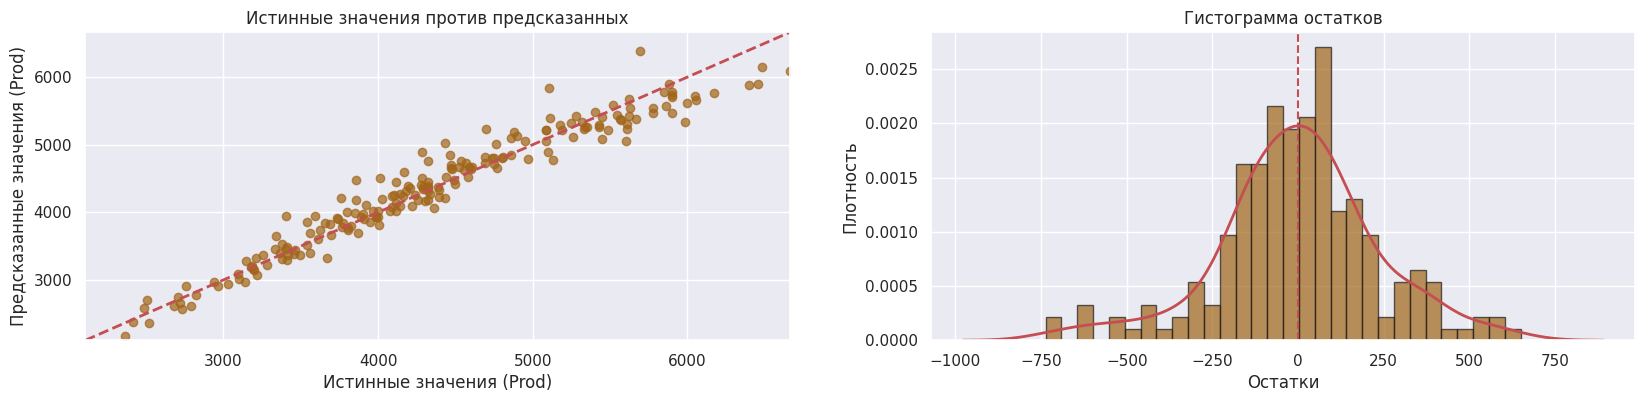

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Первой подграфик: Истинные значения против предсказанных
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Истинные значения против предсказанных')
axes[0].set_xlabel('Истинные значения (Prod)')
axes[0].set_ylabel('Предсказанные значения (Prod)')
axes[0].set_xlim(y.min(), y.max())
axes[0].set_ylim(y.min(), y.max())
axes[0].grid(True)

# Расчет остатков
residuals = y - y_pred

# Вторая подграфик: Гистограмма остатков
axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7, density=True)
# Добавление линии KDE
sns.kdeplot(residuals, color='r', lw=2, label='KDE (Ядровая оценка плотности)', ax=axes[1])

axes[1].set_title('Гистограмма остатков')
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Плотность')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].grid(True)

plt.show()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
model.fit(X_train, y_train)
print('w:', model.coef_.round())

y_pred = model.predict(X_train)

print('\nПоказатели метрик на тренировочных данных')
print(f'Корень среднеквадратичной ошибки (RMSE): {np.sqrt(mean_squared_error(y_train, y_pred)):.2f}')
print(f'Средняя абсолютная процентная ошибка (MAPE): {mean_absolute_percentage_error(y_train, y_pred) * 100 :.2f}%')

y_pred = model.predict(X_test)
print('\nПоказатели метрик на тестовых данных')
print(f'Корень среднеквадратичной ошибки (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
print(f'Средняя абсолютная процентная ошибка (MAPE): {mean_absolute_percentage_error(y_test, y_pred) * 100 :.2f}%')

w: [-1813.   296.  -190.    27.   495.]

Показатели метрик на тренировочных данных
Корень среднеквадратичной ошибки (RMSE): 238.20
Средняя абсолютная процентная ошибка (MAPE): 4.06%

Показатели метрик на тестовых данных
Корень среднеквадратичной ошибки (RMSE): 207.66
Средняя абсолютная процентная ошибка (MAPE): 4.09%


# Переходим к полиномиальной регрессии.
Этапы:
* на основе отобранных факторов сгенеририруем полиномиальные признаки третьего порядка;
* построим модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
* с помощью кросс-валидации оценим среднее значение метрик на тренировочных и валидационных фолдах.

In [69]:
X = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Создаем Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lr', LinearRegression())
])

# Получаем количество полиномиальных признаков
poly = pipeline.named_steps['poly']
n_poly_features = poly.fit_transform(X).shape[1]

print(f'Количество исходных признаков: {X.shape[1]}')
print(f'Количество полиномиальных признаков: {n_poly_features}')
print()

# Оценка качества модели на кросс-валидации с несколькими метриками
cv_results = cross_validate(
    pipeline,
    X,
    y,
    scoring={
        'mape': 'neg_mean_absolute_percentage_error',
        'rmse': 'neg_mean_squared_error'
    },
    cv=5,
    return_train_score=True
)
# Вычисление средних значений для MAPE
train_mape = -cv_results['train_mape'].mean() * 100
test_mape = -cv_results['test_mape'].mean() * 100

# Вычисление RMSE
train_rmse = np.sqrt(-cv_results['train_rmse'].mean())
test_rmse = np.sqrt(-cv_results['test_rmse'].mean())

# Вывод результатов
print('Метрики на тренировочных фолдах:')
print(f'  MAPE: {train_mape:.2f} %')
print(f'  RMSE: {train_rmse:.2f}')

print('Метрики на валидационных фолдах:')
print(f'  MAPE: {test_mape:.2f} %')
print(f'  RMSE: {test_rmse:.2f}')

Количество исходных признаков: 4
Количество полиномиальных признаков: 34

Метрики на тренировочных фолдах:
  MAPE: 1.77 %
  RMSE: 100.81
Метрики на валидационных фолдах:
  MAPE: 2.68 %
  RMSE: 156.00


> **Без полиномиальных признаков:**
* RMSE: 231.6481
* MAPE: 4.0441%
>
>**С полиномиальными признаками:**
* MAPE на тренировочных фолдах: 1.77%
* MAPE на валидационных фолдах: 2.68%
* RMSE на тренировочных фолдах: 100.81
* RMSE на валидационных фолдах: 156.00
>
>**Выводы:**
>Использование полиномиальных признаков явно привело к значительному снижению MAPE как на тренировочных, так и на валидационных фолдах. RMSE на тренировочных фолдах уменьшился также с 231.6481 до 100.81. Это означает, что предсказания модели с полиномиальными признаками более точны, чем у модели без них.
>
>Важно отметить, что разница в RMSE и MAPE между тренировочными и валидационными фолдами не слишком велика, что свидетельствует о хорошем обобщающем свойстве модели. Это значит, что модель не переобучается и хорошо работает как на тренировочных, так и на валидационных данных.

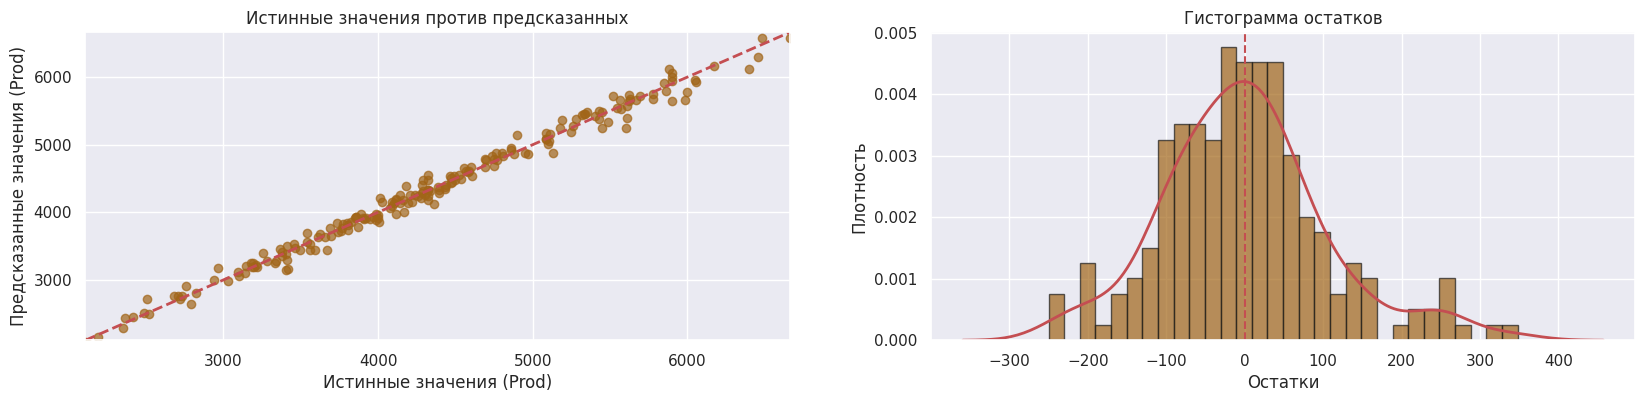

In [70]:
# Предсказания модели
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Первой подграфик: Истинные значения против предсказанных
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Истинные значения против предсказанных')
axes[0].set_xlabel('Истинные значения (Prod)')
axes[0].set_ylabel('Предсказанные значения (Prod)')
axes[0].set_xlim(y.min(), y.max())
axes[0].set_ylim(y.min(), y.max())
axes[0].grid(True)

# Расчет остатков
residuals = y - y_pred

# Вторая подграфик: Гистограмма остатков
axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7, density=True)
# Добавление линии KDE
sns.kdeplot(residuals, color='r', lw=2, label='KDE (Ядровая оценка плотности)', ax=axes[1])

axes[1].set_title('Гистограмма остатков')
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Плотность')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].grid(True)

plt.show()

# Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Этапы:
- Обучим модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.
- Коэффициент регуляризации (`alpha`) подберем с помощью библиотеки Optuna.
- Используя кросс-валидацию, оценим среднее значение метрик на тренировочных и валидационных фолдах.

In [71]:
# Определяем целевую функцию для Optuna
def objective(trial):

    alpha = trial.suggest_loguniform('alpha', 1e-4, 8.0)
    # Создаем pipeline: стандартизация, полиномиальные признаки, Lasso-регрессия
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('lasso', Lasso(alpha=alpha, random_state=random_state))
    ])

    # Используем кросс-валидацию для оценки модели
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')

    # Возвращаем среднее значение MAPE (минимизируем ошибку)
    return -scores.mean()

# Создаем объект исследования Optuna, указываем минимизацию
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=random_state), direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=False)

# Получаем лучшие параметры из Optuna
best_params = study.best_params
best_alpha = best_params['alpha']
print(f'Лучший alpha: {best_alpha}')

# Обучаем финальную модель с лучшими гиперпараметрами
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lasso', Lasso(alpha=best_alpha, random_state=random_state))
])

# Оценка качества модели на кросс-валидации с несколькими метриками
cv_results = cross_validate(
    best_pipeline,
    X,
    y,
    scoring={
        'mape': 'neg_mean_absolute_percentage_error',
        'rmse': 'neg_mean_squared_error'
    },
    cv=5,
    return_train_score=True
)
# Вычисление средних значений для MAPE
train_mape = -cv_results['train_mape'].mean() * 100
test_mape = -cv_results['test_mape'].mean() * 100

# Вычисление RMSE
train_rmse = np.sqrt(-cv_results['train_rmse'].mean())
test_rmse = np.sqrt(-cv_results['test_rmse'].mean())

print('Метрики на тренировочных фолдах:')
print(f'  MAPE: {train_mape:.2f} %')
print(f'  RMSE: {train_rmse:.2f}')

print('Метрики на валидационных фолдах:')
print(f'  MAPE: {test_mape:.2f} %')
print(f'  RMSE: {test_rmse:.2f}')

Лучший alpha: 4.59848988054146
Метрики на тренировочных фолдах:
  MAPE: 1.82 %
  RMSE: 106.40
Метрики на валидационных фолдах:
  MAPE: 2.27 %
  RMSE: 130.69


С помощью регуляризации Лассо удалось немного улучшить метрики на валидационных фолдах:
- MAPE: c 2.68 % до 2.27 %
- RMSE: со 156.00 до 130.69

Метрики на тренировочных данных и тестовых близки, что говорит о том, что у модели нет переобучения.

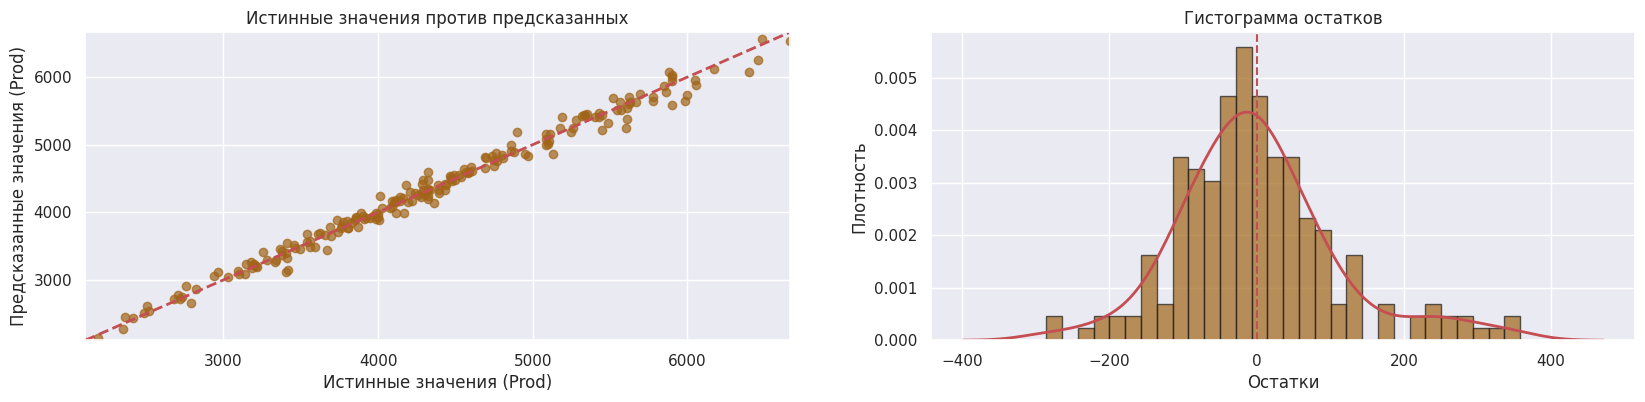

In [72]:
# Обучаем модель на полных данных
best_pipeline.fit(X, y)
y_pred = best_pipeline.predict(X)

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Первой подграфик: Истинные значения против предсказанных
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Истинные значения против предсказанных')
axes[0].set_xlabel('Истинные значения (Prod)')
axes[0].set_ylabel('Предсказанные значения (Prod)')
axes[0].set_xlim(y.min(), y.max())
axes[0].set_ylim(y.min(), y.max())
axes[0].grid(True)

# Расчет остатков
residuals = y - y_pred

# Вторая подграфик: Гистограмма остатков
axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7, density=True)
# Добавление линии KDE
sns.kdeplot(residuals, color='r', lw=2, label='KDE (Ядровая оценка плотности)', ax=axes[1])

axes[1].set_title('Гистограмма остатков')
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Плотность')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].grid(True)

plt.show()

# Переходим к $L_2$-регуляризации.

Этапы:
- Обучим модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.
- Коэффициент регуляризации (`alpha`) подберем с помощью библиотеки Optuna.
- Используя кросс-валидацию, оценим среднее значение метрик на тренировочных и валидационных фолдах.

In [73]:
# Определяем целевую функцию для Optuna
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 2)

    # Создаем pipeline: стандартизация, полиномиальные признаки, Lasso-регрессия
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('ridge', Ridge(alpha=alpha, random_state=random_state))
    ])

    # Используем кросс-валидацию для оценки модели
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')

    # Возвращаем среднее значение MAPE (минимизируем ошибку)
    return -scores.mean()

# Создаем объект исследования Optuna, указываем минимизацию
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=random_state), direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=False)

# Получаем лучшие параметры из Optuna
best_params = study.best_params
best_alpha = best_params['alpha']
print(f'Лучший alpha: {best_alpha}')

# Обучаем финальную модель с лучшими гиперпараметрами
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('ridge', Ridge(alpha=best_alpha, random_state=random_state))
])

# Оценка качества модели на кросс-валидации с несколькими метриками
cv_results = cross_validate(
    best_pipeline,
    X,
    y,
    scoring={
        'mape': 'neg_mean_absolute_percentage_error',
        'rmse': 'neg_mean_squared_error'
    },
    cv=5,
    return_train_score=True
)
# Вычисление средних значений для MAPE
train_mape = -cv_results['train_mape'].mean() * 100
test_mape = -cv_results['test_mape'].mean() * 100

# Вычисление RMSE
train_rmse = np.sqrt(-cv_results['train_rmse'].mean())
test_rmse = np.sqrt(-cv_results['test_rmse'].mean())

print('Метрики на тренировочных фолдах:')
print(f'  MAPE: {train_mape:.2f} %')
print(f'  RMSE: {train_rmse:.2f}')

print('Метрики на валидационных фолдах:')
print(f'  MAPE: {test_mape:.2f} %')
print(f'  RMSE: {test_rmse:.2f}')

Лучший alpha: 0.16186372571983193
Метрики на тренировочных фолдах:
  MAPE: 1.77 %
  RMSE: 100.88
Метрики на валидационных фолдах:
  MAPE: 2.67 %
  RMSE: 155.02


> С помощью регуляризации L2 показатели метрик улучшились на тренировочных, но ухудшились на валидационных.
>
>Метрики на тренировочных фолдах:
  - **MAPE: с 1.82 % до 1.77 %**
  - **RMSE: со 106.40 до 100.88**
>
>Метрики на валидационных фолдах:
  - MAPE: с 2.27 % увеличились до 2.67 %
  - RMSE: со 130.69 увеличились до 155.02

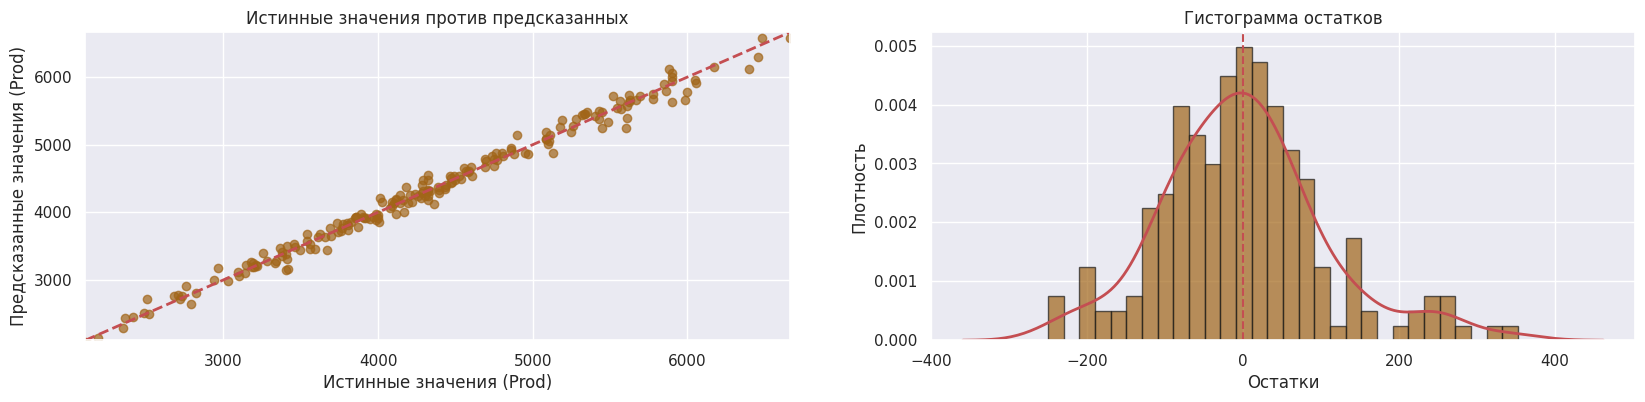

In [74]:
# Обучаем модель на полных данных
best_pipeline.fit(X, y)
y_pred = best_pipeline.predict(X)

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Первой подграфик: Истинные значения против предсказанных
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Истинные значения против предсказанных')
axes[0].set_xlabel('Истинные значения (Prod)')
axes[0].set_ylabel('Предсказанные значения (Prod)')
axes[0].set_xlim(y.min(), y.max())
axes[0].set_ylim(y.min(), y.max())
axes[0].grid(True)

# Расчет остатков
residuals = y - y_pred

# Вторая подграфик: Гистограмма остатков
axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7, density=True)
# Добавление линии KDE
sns.kdeplot(residuals, color='r', lw=2, label='KDE (Ядровая оценка плотности)', ax=axes[1])

axes[1].set_title('Гистограмма остатков')
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Плотность')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].grid(True)

plt.show()

# Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучим модель `ElasticNet` из библиотеки `sklearn` на полиномиальных факторах, предварительно стандартизировав факторы.
Этапы:
- Обучим модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы.
- Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберем с помощью библиотеки Optuna.
- Используя кросс-валидацию, оценим среднее значение метрик на тренировочных и валидационных фолдах.

In [75]:
# Определяем целевую функцию для Optuna
def objective(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-4, 2)
    l1_ratio = trial.suggest_uniform('l1_ratio', 1e-4, 1)

    # Создаем pipeline: стандартизация, полиномиальные признаки, ElasticNet
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('en', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=random_state))
    ])

    # Используем кросс-валидацию для оценки модели
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_percentage_error')

    # Возвращаем среднее значение MAPE (минимизируем ошибку)
    return -scores.mean()  # Инвертируем знак для минимизации MAPE

# Создаем объект исследования Optuna, указывая минимизацию
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=random_state), direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=False)

# Получаем лучшие параметры
best_params = study.best_params
best_alpha = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']
print(f'Лучшее значение alpha: {best_alpha}')
print(f'Лучшее значение l1_ratio: {best_l1_ratio}')

# Обучаем финальную модель с лучшими гиперпараметрами
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('en', ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=random_state))
])

# Оценка качества модели на кросс-валидации с несколькими метриками
cv_results = cross_validate(
    best_pipeline,
    X,
    y,
    scoring={
        'mape': 'neg_mean_absolute_percentage_error',
        'rmse': 'neg_mean_squared_error'
    },
    cv=5,
    return_train_score=True
)
# Вычисление средних значений для MAPE
train_mape = -cv_results['train_mape'].mean() * 100
test_mape = -cv_results['test_mape'].mean() * 100

# Вычисление RMSE
train_rmse = np.sqrt(-cv_results['train_rmse'].mean())
test_rmse = np.sqrt(-cv_results['test_rmse'].mean())

# Вывод результатов
print('Метрики на тренировочных фолдах:')
print(f'  MAPE: {train_mape:.2f} %')
print(f'  RMSE: {train_rmse:.2f}')

print('Метрики на валидационных фолдах:')
print(f'  MAPE: {test_mape:.2f} %')
print(f'  RMSE: {test_rmse:.2f}')

Лучшее значение alpha: 1.881708128270035
Лучшее значение l1_ratio: 0.9996800127489
Метрики на тренировочных фолдах:
  MAPE: 1.80 %
  RMSE: 103.28
Метрики на валидационных фолдах:
  MAPE: 2.40 %
  RMSE: 139.17


> ElasticNet проявиля себя хуже, чем регуляризация L-1, но лучще чем регуляризация L-2.

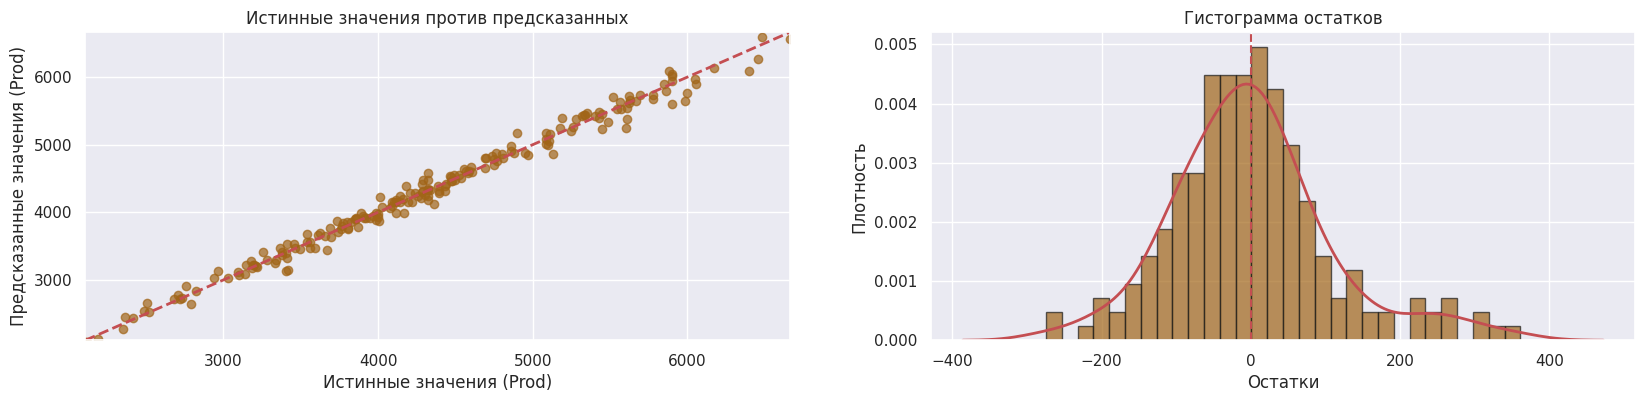

In [76]:
# Обучаем модель на полных данных
best_pipeline.fit(X, y)
y_pred = best_pipeline.predict(X)

fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Первой подграфик: Истинные значения против предсказанных
axes[0].scatter(y, y_pred, alpha=0.7)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Истинные значения против предсказанных')
axes[0].set_xlabel('Истинные значения (Prod)')
axes[0].set_ylabel('Предсказанные значения (Prod)')
axes[0].set_xlim(y.min(), y.max())
axes[0].set_ylim(y.min(), y.max())
axes[0].grid(True)

# Расчет остатков
residuals = y - y_pred

# Вторая подграфик: Гистограмма остатков
axes[1].hist(residuals, bins=30, edgecolor='k', alpha=0.7, density=True)
# Добавление линии KDE
sns.kdeplot(residuals, color='r', lw=2, label='KDE (Ядровая оценка плотности)', ax=axes[1])

axes[1].set_title('Гистограмма остатков')
axes[1].set_xlabel('Остатки')
axes[1].set_ylabel('Плотность')
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].grid(True)

plt.show()

# Сравним модели и подведем итог.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

In [77]:
df = pd.DataFrame(
    [['LinearRegression', '', False, 238.19, 207.66, 4.06, 4.09],
    ['LinearRegressionPoly', '', True, 100.81, 156.00, 1.77, 2.68],
    ['Lasso', 'alpha: 4.59848988054146', True, 106.40, 130.69, 1.82, 2.27],
    ['Ridge', 'alpha: 0.16186372571983193', True, 100.88, 155.02, 1.77, 2.67],
    ['Elactic', 'alpha: 1.881708128270035,\nl1_ratio: 0.9996800127489', True, 103.28, 139.17, 1.80, 2.40]],
    columns=['Model', 'Hyperparameters', 'PolynomialFeatures', 'RMSE_train', 'RMSE_test', 'MAPE%_train', 'MAPE%_test'])
df

,Model,Hyperparameters,PolynomialFeatures,RMSE_train,RMSE_test,MAPE%_train,MAPE%_test
0,LinearRegression,,False,238.19,207.66,4.06,4.09
1,LinearRegressionPoly,,True,100.81,156.00,1.77,2.68
2,Lasso,alpha: 4.59848988054146,True,106.40,130.69,1.82,2.27
3,Ridge,alpha: 0.16186372571983193,True,100.88,155.02,1.77,2.67
4,Elactic,"alpha: 1.881708128270035,\nl1_ratio: 0.9996800...",True,103.28,139.17,1.80,2.40


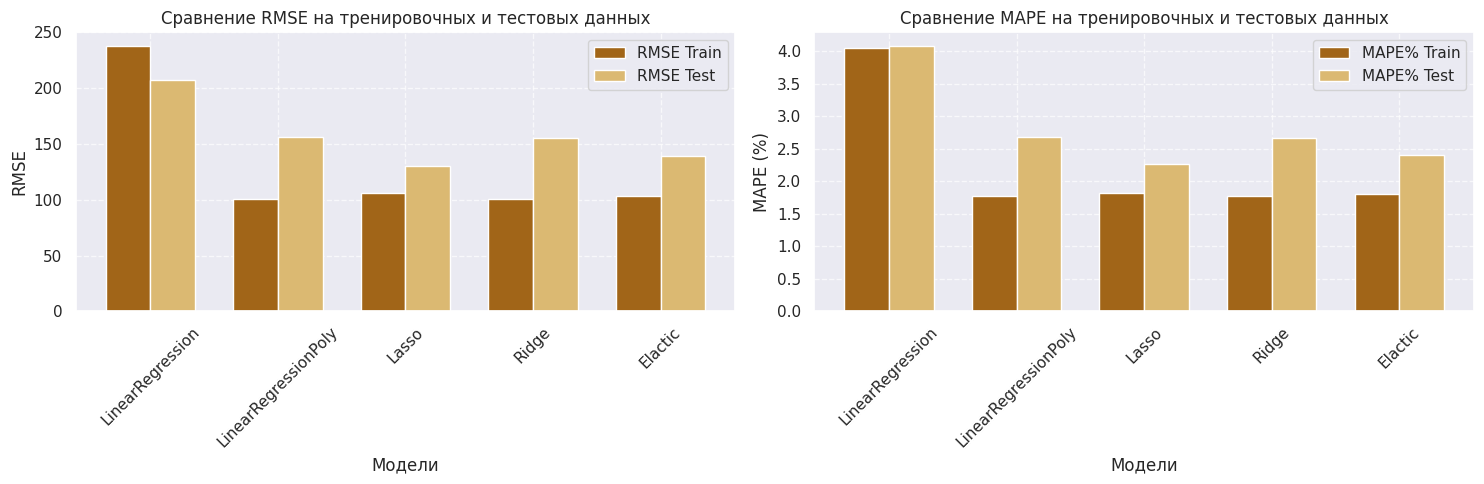

In [78]:
# Создаем подграфики
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 строка, 2 столбца

# График для RMSE
x = np.arange(len(df['Model']))  # Позиции для столбцов
width = 0.35  # Ширина столбцов

# Столбцы для тренировочных данных
axs[0].bar(x - width/2, df['RMSE_train'], width, label='RMSE Train')

# Столбцы для тестовых данных
axs[0].bar(x + width/2, df['RMSE_test'], width, label='RMSE Test')

# Настройка графика для RMSE
axs[0].set_xlabel('Модели')
axs[0].set_ylabel('RMSE')
axs[0].set_title('Сравнение RMSE на тренировочных и тестовых данных')
axs[0].set_xticks(x)
axs[0].set_xticklabels(df['Model'], rotation=45)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.7)

# График для MAPE
# Столбцы для тренировочных данных
axs[1].bar(x - width/2, df['MAPE%_train'], width, label='MAPE% Train')

# Столбцы для тестовых данных
axs[1].bar(x + width/2, df['MAPE%_test'], width, label='MAPE% Test')

# Настройка графика для MAPE
axs[1].set_xlabel('Модели')
axs[1].set_ylabel('MAPE (%)')
axs[1].set_title('Сравнение MAPE на тренировочных и тестовых данных')
axs[1].set_xticks(x)
axs[1].set_xticklabels(df['Model'], rotation=45)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

* Линейная регрессия (LinearRegression) показала самый плохой результат.
* Полиномиальная линейная регрессия (LinearRegressionPoly): Обладает самым низким RMSE на тренировочном наборе (100.81), но на тестовом наборе показатели занимают предпоследнее место(156.00). С метрикой MAPE ситуация точно такая же.
* Эластическая регрессия показала результаты, которые находятся между производительностью Lasso и Ridge для RMSE и MAPE.

**Лучшие модели:**
Lasso и Ridge: Оба этих метода имеют сопоставимые показатели RMSE и MAPE. Они показали следующие результаты:

Lasso:
- RMSE_train = 106.40,
- RMSE_test = 130.69;
- MAPE%_train = 1.82%,
- MAPE%_test = 2.27%

Ridge:
- RMSE_train = 100.88,
- RMSE_test = 155.02;
- MAPE%_train = 1.77%,
- MAPE%_test = 2.67%

Это говорит о том, что оба метода также имеют хорошую обобщающую способность, но Ridge может быть чуть менее стабильным на тестовых данных.

**Выводы:**

Lasso имеет на тестовых данных самые лучшие показатели, к тому же у нее самый маленький разброс между метриками трейна и теста, что говорит о ее стабильности и отсутсвие переобучения. Я бы рекомендовала остановиться на данном этапе именно на этой модели.

Для дальнейшего улучшения считаю нужным рассмотреть другие модели (например, случайные леса, градиентный бустинг), которые могут обеспечить еще лучшие результаты.